In [ ]:
!nvidia-smi

In [ ]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb kaggle pytorch-nlp 
!pip install wandb --quiet
!pip install torchsummaryX -q

In [ ]:
!pip install torchmetrics

# Imports

In [ ]:
# Import Necessary Modules you require for this HW here
import torch
from torch import nn
from torchsummaryX import summary
import torchnlp
import torchnlp.nn
from torchnlp.nn import LockedDropout
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import os
import gc
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import glob
# import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)
import json
import Levenshtein
import seaborn as sns
import torchaudio
import torchmetrics

In [ ]:
# To download the dataset
!kaggle datasets download -d varunjain3/11-785-s23-hw4p2-dataset

In [ ]:
# To unzip data quickly and quietly
!unzip -q 11-785-s23-hw4p2-dataset.zip -d ./data

In [ ]:
config = {
  'batch_size': 150,
  'lr':1e-3,
  'epochs': 1,
}

VOCAB = ['<pad>', '<sos>', '<eos>', 
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         ]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of vocab: {len(VOCAB)}")
print(f"Vocab: {VOCAB}")
print(f"PAD_TOKEN: {PAD_TOKEN}")
print(f"SOS_TOKEN: {SOS_TOKEN}")
print(f"EOS_TOKEN: {EOS_TOKEN}")

In [ ]:
class SpeechDataset(torch.utils.data.Dataset):
  '''
  Feel free to add arguments, additional functions, this is the 
  bare-minimum template.
  '''
  def __init__(self, root = "/content/data", vocab_map = VOCAB_MAP, partition = "train-clean-100"):
    self.vocab_map = vocab_map
    self.mfcc_dir = os.path.join(root,partition)+"/mfcc" #TODO
    self.transcript_dir = os.path.join(root,partition)+"/transcripts" #TODO
    mfcc_names          = sorted(os.listdir(self.mfcc_dir))
    transcript_names    = sorted(os.listdir(self.transcript_dir))
    assert len(mfcc_names) == len(transcript_names)

    self.mfccs = []#TODO
    self.transcripts = []#TODO
    for i in range(len(mfcc_names)):
        mfcc        = np.load(os.path.join(self.mfcc_dir,mfcc_names[i]))
        mfcc        = mfcc - (np.sum(mfcc, axis = 0)/mfcc.shape[0])
        transcript  = np.load(os.path.join(self.transcript_dir,transcript_names[i])) # Remove [SOS] and [EOS] from the transcript
        # transcript = transcript.astype(np.uint8) 
        self.mfccs.append(mfcc)
        self.transcripts.append(transcript)

    self.length = len(self.mfccs)
    self.transcripts = [np.array([self.vocab_map[i] for i in seq]) for seq in self.transcripts]

  def __len__(self):
    return self.length
  
  def __getitem__(self, ind):

    mfcc = torch.FloatTensor(self.mfccs[ind])
    transcript = torch.tensor(self.transcripts[ind])

    return mfcc, transcript

  
  def collate_fn(self, batch):

    x_batch, y_batch = list(zip(*batch))
    # batch_mfcc = []
    # batch_transcript = []
    # lengths_mfcc = []
    # lengths_transcript = []
    # for data, label in batch:
    #   batch_mfcc.append(data)
    #   batch_transcript.append(label)
    #   lengths_mfcc.append(len(data))
    #   lengths_transcript.append(len(label))

    
    x_lens      = [x.shape[0] for x in x_batch] 
    y_lens      = [y.shape[0] for y in y_batch] 
    
    x_batch_pad = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value= PAD_TOKEN)
    y_batch_pad = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value= PAD_TOKEN)

    return x_batch_pad, y_batch_pad, torch.tensor(x_lens), torch.tensor(y_lens)


In [ ]:
class SpeechDatasetTest(torch.utils.data.Dataset):
  '''
  Feel free to add arguments, additional functions, this is the 
  bare-minimum template.
  '''
  def __init__(self, root = "/content/data", vocab_map = VOCAB_MAP, partition = "test-clean"):
    self.vocab_map = vocab_map
    self.mfcc_dir = os.path.join(root,partition)+"/mfcc" #TODO
    mfcc_names          = sorted(os.listdir(self.mfcc_dir))



    self.mfccs = []#TODO
    for i in range(len(mfcc_names)):
        mfcc        = np.load(os.path.join(self.mfcc_dir,mfcc_names[i]))
        mfcc        = mfcc - (np.sum(mfcc, axis = 0)/mfcc.shape[0])
        self.mfccs.append(mfcc)

    self.length = len(self.mfccs)

  def __len__(self):
    return self.length
  
  def __getitem__(self, ind):

    mfcc = torch.FloatTensor(self.mfccs[ind])

    return mfcc

  
  def collate_fn(self, batch):
    
    batch_mfcc = []  # TODO
    lengths_mfcc = []

    for data in batch:
        batch_mfcc.append(data)
        lengths_mfcc.append(len(data)) 

    batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first = True, padding_value = PAD_TOKEN)

    return batch_mfcc_pad, torch.tensor(lengths_mfcc)

In [ ]:
train_data = SpeechDataset(partition = "train-clean-100") #TODO
val_data = SpeechDataset(partition = "dev-clean")
test_data = SpeechDatasetTest()

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data, 
    num_workers = 6,
    batch_size  = config['batch_size'], 
    pin_memory  = True,
    shuffle     = True,
    collate_fn  = train_data.collate_fn
)#TODO
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data, 
    num_workers = 2,
    batch_size  = config['batch_size'], 
    pin_memory  = True,
    shuffle     = True,
    collate_fn  = val_data.collate_fn
)#TODO
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data, 
    num_workers = 1,
    batch_size  = config['batch_size'], 
    pin_memory  = True,
    shuffle     = False,
    collate_fn  = test_data.collate_fn
) 


In [ ]:
print("\nChecking the shapes of the data...")
for batch in train_loader:
    x, y, lx, ly = batch
    print(x.shape, y.shape, lx.shape, ly.shape)
    break



Checking the shapes of the data...
torch.Size([150, 1690, 27]) torch.Size([150, 336]) torch.Size([150]) torch.Size([150])


Check if you are loading the data correctly with the following:

(Note: These are outputs from loading your data in the dataset class, not your dataloader which will have padded sequences)

- Train Dataset
```
Partition loaded:  train-clean-100
Max mfcc length:  2448
Average mfcc length:  1264.6258453344547
Max transcript:  400
Average transcript length:  186.65321139493324
```

- Dev Dataset
```
Partition loaded:  dev-clean
Max mfcc length:  3260
Average mfcc length:  713.3570107288198
Max transcript:  518
Average transcript length:  108.71698113207547
```

- Test Dataset
```
Partition loaded:  test-clean
Max mfcc length:  3491
Average mfcc length:  738.2206106870229
```

If your values is not matching, read hints, think what could have gone wrong. Then approach TAs.

# THE MODEL 

### Listen, Attend and Spell
Listen, Attend and Spell (LAS) is a neural network model used for speech recognition and synthesis tasks.

- LAS is designed to handle long input sequences and is robust to noisy speech signals.
- LAS is known for its high accuracy and ability to improve over time with additional training data.
- It consists of an <b>listener, an attender and a speller</b>, which work together to convert an input speech signal into a corresponding output text.

#### The Dataflow:
<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/DataFlow.png" alt="data flow" height="100">
</center>

#### The Listener: 
- converts the input speech signal into a sequence of hidden states.

#### The Attender:
- Decides how the sequence of Encoder hidden state is propogated to decoder.

#### The Speller:
- A language model, that incorporates the "context of attender"(output of attender) to predict sequence of words.






## The Listener:

Psuedocode:
```python
class Listner:
  def init():
    feature_embedder = #Few layers of 1DConv-batchnorm-activation (Don't overdo)
    pblstm_encoder = #Cascaded pblstm layers (Take pblstm from #HW3P2), 
    #can add more sequential lstms 
    dropout = #As per your liking

  def forward(x,lx):
    embedding = feature_embedder(x) #optional
    encoding, encoding_len = pblstm_encoder(embedding/x,lx)
    #Regularization if needed
    return encoding, encoding_len
```



In [ ]:

class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)
        
class pBLSTM(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1, batch_first = True, dropout = 0.18, bidirectional = True) # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size
    
    
    def forward(self, x_packed):
        x, seq_length = pad_packed_sequence(x_packed, batch_first = True, padding_value = PAD_TOKEN)
        x_downsampled, x_lens = self.trunc_reshape(x, seq_length)
        # print("x downsampled shape: ",x_downsampled.shape)
        x_down_packed = pack_padded_sequence(x_downsampled, x_lens, batch_first = True, enforce_sorted = False)
        output, _ = self.blstm(x_down_packed)
        return output, x_lens

    def trunc_reshape(self, x, x_lens): 
        batch_size, t_step, feature_dim = x.shape

        if t_step % 2 != 0:
          x = x[:,:-1,:]
          t_step -= 1

        x = x.reshape((batch_size, int(t_step/2), feature_dim*2))
        x_lens = x_lens//2
        return x, x_lens

In [ ]:
class Listener(torch.nn.Module):
  def __init__(self, input_size, encoder_hidden_size):
    super(Listener, self).__init__()
    
    self.embedding = torch.nn.Sequential(
              torch.nn.Conv1d(in_channels=input_size,out_channels=150,kernel_size=5,padding=2),
              torch.nn.BatchNorm1d(150),
              torch.nn.GELU(),
              torch.nn.Conv1d(in_channels=150,out_channels= 4*encoder_hidden_size,kernel_size=5,padding=2)
              )#TODO: You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.

    self.lock_drop = LockedDropout(p = 0.15)

    self.pblstm1 = pBLSTM(input_size = 2*2*2*encoder_hidden_size, hidden_size = 2*encoder_hidden_size)
    self.pblstm2 = pBLSTM(input_size = 2*2*2*encoder_hidden_size, hidden_size = 2*encoder_hidden_size)
    # self.pblstm3 = pBLSTM(input_size = 2*2*2*encoder_hidden_size, hidden_size = 2*encoder_hidden_size)
    self.permute = PermuteBlock()

  def forward(self, x, x_lens):
    x = self.permute(x)
    x = self.embedding(x)
    x = self.permute(x)


    # x = self.permute(x)
    # x = self.lock_drop1(x)
    # x = self.permute(x)

    x = pack_padded_sequence(x, lengths = x_lens, batch_first = True, enforce_sorted = False)


    pblstm1_out, x_lens = self.pblstm1(x)
    pblstm1_out, x_lens = pad_packed_sequence(pblstm1_out, batch_first = True, padding_value = PAD_TOKEN)

    pblstm1_out = pblstm1_out.transpose(0,1)
    pblstm1_out = self.lock_drop(pblstm1_out)
    pblstm1_out = pblstm1_out.transpose(0,1)
    
    pblstm1_out = pack_padded_sequence(pblstm1_out, lengths = x_lens, batch_first = True, enforce_sorted = False)

    pblstm2_out, x_lens = self.pblstm2(pblstm1_out)
    pblstm2_out, x_lens = pad_packed_sequence(pblstm2_out, batch_first=True, padding_value = PAD_TOKEN)
    # pblstm2_out = self.permute(pblstm2_out)
    # pblstm2_out = self.lock_drop(pblstm2_out)
    # pblstm2_out = self.permute(pblstm2_out)
    # pblstm2_out = pack_padded_sequence(pblstm2_out, lengths = x_lens, batch_first = True, enforce_sorted = False)

    # pblstm3_out, x_lens = self.pblstm3(pblstm2_out)
    # pblstm3_out, x_lens = pad_packed_sequence(pblstm3_out, batch_first=True, padding_value = PAD_TOKEN)

    

    return pblstm2_out, x_lens


## Attention

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

Pseudocode:

```python
class Attention:
    '''
    Attention is calculated using the key, value (from encoder embeddings) and query from decoder.

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    attention_weights   = softmax(raw_weights)
    attention_context   = einsum("thinkwhatwouldbetheequationhere",attention, value) #take hint from raw_weights calculation

    At the end, you can pass context through a linear layer too.
    '''

    def init(listener_hidden_size,
              speller_hidden_size,
              projection_size):

        VW = Linear(listener_hidden_size,projection_size)
        KW = Linear(listener_hidden_size,projection_size)
        QW = Linear(speller_hidden_size,projection_size)

    def set_key_value(encoder_outputs):
        '''
        In this function we take the encoder embeddings and make key and values from it.
        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        '''
        key = KW(encoder_outputs)
        value = VW(encoder_outputs)
      
    def compute_context(decoder_context):
        '''
        In this function from decoder context, we make the query, and then we
         multiply the queries with the keys to find the attention logits, 
         finally we take a softmax to calculate attention energy which gets 
         multiplied to the generted values and then gets summed.

        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        query.shape = (batch_size, projection_size)

        You are also recomended to check out Abu's Lecture 19 to understand Attention better.
        '''
        query = QW(decoder_context) #(batch_size, projection_size)

        raw_weights = #using bmm or einsum. We need to perform batch matrix multiplication. It is important you do this step correctly.
        #What will be the shape of raw_weights?

        attention_weights = #What makes raw_weights -> attention_weights

        attention_context = #Multiply attention weights to values

        return attention_context, attention_weights 
```

In [ ]:
class Attention(torch.nn.Module):

  def __init__(self, listener_size, speller_size, projection_size):
    super().__init__()
    
    self.VW = torch.nn.Linear(listener_size,projection_size)
    self.KW = torch.nn.Linear(listener_size,projection_size)
    self.QW = torch.nn.Linear(speller_size,projection_size)
    self.softmax = torch.nn.Softmax(dim=1)

  def set_key_value(self, encoder_outputs):
    # print(encoder_outputs.shape)
    self.key = self.KW(encoder_outputs)
    self.value = self.VW(encoder_outputs)

  def compute_context(self, decoder_context):

    self.query = self.QW(decoder_context)
    self.query = torch.unsqueeze(self.query,2)
    length_q = self.query.shape[1]
    # print("key: ", self.key.shape)
    # print("q: ", self.query.shape)
    raw_weights = torch.bmm(self.key, self.query).squeeze()
    attention_weights = self.softmax(raw_weights/np.sqrt(length_q))
    attention_context = torch.einsum('bi,bij->bj', attention_weights,self.value)

    return attention_context, attention_weights

In [ ]:
np.sqrt(9)

3.0

## The Speller

Similar to the language model that you coded up for HW4P1, you have to code a language model for HW4P2 as well. This time, we will also call the attention context step, within the decoder to get the attended-encoder-embeddings.


What you have coded till now:

<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/EncoderAttention.png" alt="data flow" height="400">
</center>

For the Speller, what we have to code:


<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/Decoder.png" alt="data flow" height="400">
</center>

In [ ]:
a = torch.rand(4,5)
b = torch.rand(4,6)
torch.cat((a,b),dim=1).shape

torch.Size([4, 11])

In [ ]:
class Speller(torch.nn.Module):

  # Refer to your HW4P1 implementation for help with setting up the language model.
  # The only thing you need to implement on top of your HW4P1 model is the attention module and teacher forcing.

  def __init__(self, vocab_size, embedding_size, projection_size, speller_size, attender):
    super(). __init__()

    lstm_size = embedding_size+projection_size
    self.attend = attender # Attention object in speller
    self.max_timesteps = 550 # Max timesteps
    self.projection_size = projection_size

    self.embedding =  torch.nn.Embedding(vocab_size, embedding_size) # Embedding layer to convert token to latent space

    self.lstm_cells =  torch.nn.Sequential(
            torch.nn.LSTMCell(lstm_size, speller_size),
            torch.nn.LSTMCell(speller_size, speller_size),
            torch.nn.LSTMCell(speller_size, speller_size)
        )# Create a sequence of LSTM Cells
    

    # For CDN (Feel free to change)
    self.output_to_char = torch.nn.Linear(speller_size+projection_size, embedding_size)# Linear module to convert outputs to correct hidden size (Optional: TO make dimensions match)
    self.activation = torch.nn.GELU()# Check which activation is suggested
    self.dropout = torch.nn.Dropout(p=0.15)

    self.linear1 = torch.nn.Linear(embedding_size, embedding_size)
    self.linear2 = torch.nn.Linear(embedding_size, embedding_size)
    self.char_prob = torch.nn.Linear(embedding_size, vocab_size) # Linear layer to convert hidden space back to logits for token classification
    self.char_prob.weight = self.embedding.weight# Weight tying (From embedding layer)
    self.apply(self._init_weights)

  def lstm_step(self, embedding, hidden_states_list):

    for i in range(len(self.lstm_cells)):
        if i == 0:
          embedding, cell_state = self.lstm_cells[i](embedding,hidden_states_list[i]) # Feed the input through each LSTM Cell
        else:
          embedding, cell_state = self.lstm_cells[i](embedding,hidden_states_list[i])

        hidden_states_list[i] = (embedding, cell_state)
        
    return embedding, hidden_states_list # What information does forward() need?
    
  def CDN(self, input):
    # Make the CDN here, you can add the output-to-char
    # print("input",input.shape)
    # print("lstm size", )
    out = self.activation(self.output_to_char(self.dropout(input)))
    out = self.activation(self.linear1(self.dropout(out)))
    out = self.activation(self.linear2(self.dropout(out)))
    out = self.char_prob(out)
    return out
  
  def _init_weights(self, module):
    if isinstance(module, nn.LSTMCell):
     torch.nn.init.uniform_(module.weight_ih, -0.1, 0.1)
     torch.nn.init.uniform_(module.weight_hh, -0.1, 0.1)

  def forward (self,x, y=None, teacher_forcing_ratio=1):
    batch_size = x.shape[0]

    attn_context = torch.zeros(batch_size, self.projection_size).to(DEVICE)# initial context tensor for time t = 0
    output_symbol = torch.full((batch_size,), SOS_TOKEN).to(DEVICE) # Set it to SOS for time t = 0
    
    raw_outputs = []  
    attention_plot = []
      
    if y is None:
      timesteps = self.max_timesteps
      teacher_forcing_ratio = 0 #Why does it become zero?

    else:
      timesteps = y.shape[1] # How many timesteps are we predicting for?

    hidden_states_list = [None] * len(self.lstm_cells)# Initialize your hidden_states list here similar to HW4P1

    for t in range(timesteps):
      p = random.uniform(0,1)# generate a probability p between 0 and 1

      if p < teacher_forcing_ratio and t > 0: # Why do we consider cases only when t > 0? What is considered when t == 0? Think.
        output_symbol = y[:,t-1] # Take from y, else draw from probability distribution

      # elif p > teacher_forcing_ratio and t > 0:
      char_embed = self.embedding(output_symbol) # Embed the character symbol

      # Concatenate the character embedding and context from attention, as shown in the diagram
      lstm_input = torch.cat((char_embed,attn_context), dim = 1)

      lstm_out, hidden_states_list = self.lstm_step(lstm_input, hidden_states_list) # Feed the input through LSTM Cells and attention.
      # What should we retrieve from forward_step to prepare for the next timestep?

      attn_context, attn_weights = self.attend.compute_context(lstm_out) # Feed the resulting hidden state into attention

      cdn_input = torch.cat((lstm_out,attn_context), dim = 1)# TODO: You need to concatenate the context from the attention module with the LSTM output hidden state, as shown in the diagram

      raw_pred = self.CDN(cdn_input) # call CDN with cdn_input

      # Generate a prediction for this timestep and collect it in output_symbols
      # print(raw_pred.shape)
      output_symbol = torch.argmax(raw_pred, dim = 1)# Draw correctly from raw_pred

      raw_outputs.append(raw_pred) # for loss calculation
      attention_plot.append(attn_weights) # for plotting attention plot

    
    attention_plot = torch.stack(attention_plot, dim=1)
    raw_outputs = torch.stack(raw_outputs, dim=1)

    return raw_outputs, attention_plot

In [ ]:
a = torch.rand(5,4)
b = torch.rand(5,3)
c = torch.cat((a,b), dim = 1)


In [ ]:
c.shape

torch.Size([5, 7])

## LAS

Here we finally build the LAS model, comibining the listener, attender and speller together, we have given a template, but you are free to read the paper and implement it yourself.

In [ ]:
class LAS(torch.nn.Module):
  def __init__(self, vocab_size, embedding_size, input_size, encoder_hidden_size, listener_size, speller_size, projection_size): # add parameters
    super().__init__()
    self.name = "LAS"
    # Pass the right parameters here
    self.listener = Listener(input_size, encoder_hidden_size)
    self.attend = Attention(listener_size, speller_size, projection_size)
    self.speller = Speller(vocab_size, embedding_size, projection_size, speller_size, self.attend)

    self.aug = torch.nn.Sequential(
        PermuteBlock(),
        torchaudio.transforms.TimeMasking(10),
        torchaudio.transforms.FrequencyMasking(5),
        PermuteBlock()
    )
  def forward(self, x,lx,y=None,teacher_forcing_ratio=1):
    # Encode speech features
    if self.training:
      x = self.aug(x)
      
    encoder_outputs, _ = self.listener(x,lx)

    # We want to compute keys and values ahead of the decoding step, as they are constant for all timesteps
    # Set keys and values using the encoder outputs
    # print(encoder_outputs.shape)
    self.attend.set_key_value(encoder_outputs)

    # Decode text with the speller using context from the attention
    raw_outputs, attention_plots = self.speller(x, y,teacher_forcing_ratio=teacher_forcing_ratio)

    return raw_outputs, attention_plots

# Model Setup 

In [ ]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 
# Attention Projection Size of 128
# Feel Free to Experiment with this 

# vocab_size, speller_embedding_size, input_size, listener_hidden_size, listener_size, speller_size, projection_size
model = LAS(
    # Initialize your model 
    # Read the paper and think about what dimensions should be used
    # You can experiment on these as well, but they are not requried for the early submission
    # Remember that if you are using weight tying, some sizes need to be the same
    vocab_size=31,
    embedding_size=350,
    input_size=27,
    encoder_hidden_size=240,
    listener_size = 4*240,
    speller_size = 560,
    projection_size = 300
)

model = model.to(DEVICE)
print(model)

summary(model, 
        x.to(DEVICE), 
        lx,
        y.to(DEVICE))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LAS(
  (listener): Listener(
    (embedding): Sequential(
      (0): Conv1d(27, 150, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv1d(150, 960, kernel_size=(5,), stride=(1,), padding=(2,))
    )
    (lock_drop): LockedDropout(p=0.15)
    (pblstm1): pBLSTM(
      (blstm): LSTM(1920, 480, batch_first=True, dropout=0.18, bidirectional=True)
    )
    (pblstm2): pBLSTM(
      (blstm): LSTM(1920, 480, batch_first=True, dropout=0.18, bidirectional=True)
    )
    (permute): PermuteBlock()
  )
  (attend): Attention(
    (VW): Linear(in_features=960, out_features=300, bias=True)
    (KW): Linear(in_features=960, out_features=300, bias=True)
    (QW): Linear(in_features=560, out_features=300, bias=True)
    (softmax): Softmax(dim=1)
  )
  (speller): Speller(
    (attend): Attention(
      (VW): Linear(in_features=960, out_features=300, bias=True)
      (K

/usr/local/lib/python3.9/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                Kernel Shape     Output Shape Params Mult-Adds
Layer                                                                         
0_aug.PermuteBlock_0                       -  [150, 27, 1690]      -         -
1_aug.TimeMasking_1                        -  [150, 27, 1690]      -         -
2_aug.FrequencyMasking_2                   -  [150, 27, 1690]      -         -
3_aug.PermuteBlock_3                       -  [150, 1690, 27]      -         -
4_listener.PermuteBlock_permute            -  [150, 27, 1690]      -         -
...                                      ...              ...    ...       ...
6060_speller.GELU_activation               -       [150, 350]      -         -
6061_speller.Dropout_dropout               -       [150, 350]      -         -
6062_speller.Linear_linear2       [350, 350]       [150, 350]      -    122.5k
6063_speller.GELU_activation               -       [150, 350]      -         -
6064_speller.Linear_char_prob      [350, 31]        

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_aug.PermuteBlock_0,-,"[150, 27, 1690]",NaN,NaN
1_aug.TimeMasking_1,-,"[150, 27, 1690]",NaN,NaN
2_aug.FrequencyMasking_2,-,"[150, 27, 1690]",NaN,NaN
3_aug.PermuteBlock_3,-,"[150, 1690, 27]",NaN,NaN
4_listener.PermuteBlock_permute,-,"[150, 27, 1690]",NaN,NaN
...,...,...,...,...
6060_speller.GELU_activation,-,"[150, 350]",NaN,NaN
6061_speller.Dropout_dropout,-,"[150, 350]",NaN,NaN
6062_speller.Linear_linear2,"[350, 350]","[150, 350]",NaN,122500.0


# Loss Function, Optimizers, Scheduler

In [ ]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr']) # Feel free to experiment if needed
criterion   = torch.nn.CrossEntropyLoss(reduction='mean',ignore_index=PAD_TOKEN) #check how would you fill these values : https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 70, eta_min = 0.000001)

# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

# Levenshtein Distance

In [ ]:

# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[int(i)])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape
    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)
        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above and uncomment below for toy dataset, as the toy dataset has a list of phonemes to compare
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)
    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        wer = torchmetrics.WordErrorRate()
        temp_wer = wer(y_string, pred_string)
        print("Word Error Rate: ", temp_wer)
        # if batch_idx ==0:
        #   total_wer = 0
        # total_wer +=  wer(y_string, pred_string)


    dist/=batch_size
    return dist, temp_wer

# Train and Validation functions 


In [ ]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            raw_predictions, attention_plot = model(x, lx, y, teacher_forcing_rate)

            # Predictions are of Shape (batch_size, timesteps, vocab_size). 
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            # Also we recommend you plot the attention weights, you should get convergence in around 10 epochs, if not, there could be something wrong with 
            # your implementation

            raw_predictions = torch.permute(raw_predictions, (0,2,1))
            loss        =  criterion(raw_predictions, y)# TODO: Cross Entropy Loss

            perplexity  = torch.exp(loss) # Perplexity is defined the exponential of the loss

            running_loss        += loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss
        scaler.scale(loss).backward()

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping
        
        scaler.step(optimizer)
        scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [ ]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0
    total_wer = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        # print("predictions shape: ",raw_predictions.shape)
        greedy_predictions   = torch.argmax(raw_predictions, dim=2) # TODO: How do you get the most likely character from each distribution in the batch?
        
        # Calculate Levenshtein Distance
        temp_lev_dist, temp_total_wer  = calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = True) # You can use print_example = True for one specific index i in your batches if you want
        running_lev_dist += temp_lev_dist
        total_wer += temp_total_wer
        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist, total_wer

# Experiment

In [ ]:
# Login to Wandb
import wandb
wandb.login(key="2cdffa7876dcc502447ef1cd147b4f60b0f4e74b")
# Initialize your Wandb Run Here
run = wandb.init(
    name = "Run1", ## Wandb creates random run names if you skip this field
    #reinit = True, ### Allows reinitalizing runs when you re-run this cell
    id = 'nfwe2ti9',### Insert specific run id here if you want to resume a previous run
    resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "project_ablations", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)
# Save your model architecture in a txt file, and save the file to Wandb

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


lr,0.001
tf_ratio,1
train_loss,0.03857
valid_dist,15.34912


In [ ]:
def plot_attention(attention): 
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         metric[0]                  : metric[1], 
         'epoch'                    : epoch}, 
         path
    )

In [ ]:
gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.9/dist-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (nfwe2ti9) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),



Epoch: 1/1


Val:   5%|▌         | 1/19 [00:02<00:48,  2.67s/it, dist=14.6533]

Ground Truth :  THEY STAND UNMOVED IN THEIR SOLITARY GREATNESS WELL ASSURED THAT THEY ARE SEEN OF ALL THE WORLD WITHOUT ANY EFFORT TO SHOW THEMSELVES OFF AND THAT NO ONE WILL ATTEMPT TO DRIVE THEM FROM THAT POSITION
Prediction   :  THEY STAND A MOVE IN THEIR SOLITARY GRAPES WELL AS YOU ARE THE BARE SEEN OF OLD A WORLD WITHOUT ANY EFFORT TO SHOW THEMSELVES OFF AND AT NO ONE WILL ATTEMPT TO DRIVE THEM FROM THE POSITION
Word Error Rate:  tensor(0.3158)


Val:  11%|█         | 2/19 [00:05<00:43,  2.55s/it, dist=15.9800]

Ground Truth :  HE SAW THAT IN THE EXCITEMENT OF RECENT EVENTS HE HAD NOT FORMULATED A PLAN UPON THAT SCORE
Prediction   :  HE SAW THAT IN THE EXCITEMENT EFFECING THE BENCH HE HAD NOT FORMULATED A PLAN UPON THAT SCORE
Word Error Rate:  tensor(0.1667)


Val:  16%|█▌        | 3/19 [00:07<00:40,  2.54s/it, dist=16.4178]

Ground Truth :  HE CHECKED THE SILLY IMPULSE
Prediction   :  HE TACT THIS ONLY IMPULSE
Word Error Rate:  tensor(0.6000)


Val:  21%|██        | 4/19 [00:10<00:38,  2.56s/it, dist=16.0783]

Ground Truth :  THE FEEBLE SON OF ARCADIUS WAS ALTERNATELY SWAYED BY HIS WIFE AND SISTER BY THE EUNUCHS AND WOMEN OF THE PALACE SUPERSTITION AND AVARICE WERE THEIR RULING PASSIONS AND THE ORTHODOX CHIEFS WERE ASSIDUOUS IN THEIR ENDEAVORS TO ALARM THE FORMER AND TO GRATIFY THE LATTER
Prediction   :  THE FEEBLE SUN OF OUR KEITIES WAS ALTONATELY SWEED BY HIS WIFE AND SISTER BY THE UNICS AND WOMEN OF THE PALACE SUPERSTITION AND AVARICE WERE THEIR ROLLING PASSIONS AND THE ORDER OF CHEETS WERE A SIDIER IS IN THEIR ENDEAVOURS TO ALARM THE FORMER AND TO GRATIFY THE LETTER
Word Error Rate:  tensor(0.3000)


Val:  26%|██▋       | 5/19 [00:12<00:36,  2.57s/it, dist=15.9587]

Ground Truth :  DO HIM GOOD CURSE HIM
Prediction   :  DO HEN GOOD CARSON
Word Error Rate:  tensor(0.7500)


Val:  32%|███▏      | 6/19 [00:15<00:33,  2.55s/it, dist=15.7800]

Ground Truth :  MEANWHILE ALL THE REST OF THE PEOPLE IN THE CASTLE HAD BEEN WAKENED AT THE SAME MOMENT AS THE PRINCESS AND THEY WERE NOW EXTREMELY HUNGRY
Prediction   :  MEANWHILE ALL THE REST OF THE PEOPLE AND THE CASTLE HAD BEEN AWAKENED AT THE SAME MOMENT AS THE PRINCESS AND THEY WERE NOW EXTREMELY HONGRY
Word Error Rate:  tensor(0.1154)


Val:  37%|███▋      | 7/19 [00:17<00:29,  2.49s/it, dist=15.3667]

Ground Truth :  THAT'S MACKLEWAIN'S BUSINESS
Prediction   :  THAT'S MACHACAME'S BUSINESS
Word Error Rate:  tensor(0.3333)


Val:  42%|████▏     | 8/19 [00:20<00:27,  2.48s/it, dist=15.1575]

Ground Truth :  SOMETHING HAD TO BE DONE A CLIMAX WAS NEAR AND SHE WOULD NOT SIT IDLE
Prediction   :  SOMETHING HAD TO BE DONE A CLANCE WAS NEAR AND SHE WOULD NOT SAID IDLE
Word Error Rate:  tensor(0.1333)


Val:  47%|████▋     | 9/19 [00:22<00:25,  2.52s/it, dist=15.5163]

Ground Truth :  IN THE MEANWHILE THE MINDS OF MEN CUT ADRIFT FROM THEIR ANCIENT MOORINGS WANDERED WILDLY OVER PATHLESS SEAS OF SPECULATIVE DOUBT AND ESPECIALLY IN THE MORE METAPHYSICAL AND CONTEMPLATIVE EAST ATTEMPTED TO SOLVE FOR THEMSELVES THE QUESTIONS OF MAN'S RELATION TO THE UNSEEN BY THOSE THOUSAND SCHISMS HERESIES AND THEOSOPHIES IT IS A DISGRACE TO THE WORD PHILOSOPHY TO CALL THEM BY IT ON THE RECORDS OF WHICH THE STUDENT NOW GAZES BEWILDERED UNABLE ALIKE TO COUNT OR TO EXPLAIN THEIR FANTASIES
Prediction   :  IN THE MEANWHILE THE MINDS OF MEN COUNTED DRIFT FROM THEIR ANCIENT MOORINGS WATER WILDLY OVER PATFUL A SEAS OF SPECULES OF DOUBT AND DESPECIALLY IN THE MORE METIPHYSICAL AND CONTEMPLATIVE EAST ATTEMPTED TO SAW FOR THEMSELVES THE QUESTIONS OF MAN'S RELATION TO THE UNSEA BY THOSE THOUSAND SKISSMES HARRIS EASE AND THE ALSIFIES THE STUDENT THE WORD PHILOSOPHY TO CALL THEM BY IT ON THE RECORDS OF WHICH THE STUDENT THOU GAZED AS BE WILDERED ON THE RECORDS OF WHICH THE STUDENT TH

Val:  53%|█████▎    | 10/19 [00:25<00:22,  2.54s/it, dist=15.8613]

Ground Truth :  WILL HALLEY IS A BRUTE BUT I AM KEEPING MY EYES OPEN AND IF THE COAST LOOKS DANGEROUS I WILL PUT THE SHIP'S HEAD TO SEA AGAIN
Prediction   :  WELL HOW HE IS IT BORN BUT I AM KEEP IN MY EYES OPEN AND THAT THE COAST LOOKS VANIERACE OUL PUT THE SHIP'S HEAD TO SEE AGAIN
Word Error Rate:  tensor(0.4286)


Val:  58%|█████▊    | 11/19 [00:27<00:20,  2.52s/it, dist=15.8855]

Ground Truth :  THEN HE SAT DOWN IN HIS CHAIR AND GAZED WITHOUT SEEING CONTEMPLATING THE RESULT OF HIS WORK
Prediction   :  THEN HE SAT DOWN IN HIS CHAIR AND GAZED WITHOUT SEEING CONTAIN BUTTING THE RESULT OF HIS WORK
Word Error Rate:  tensor(0.1111)


Val:  63%|██████▎   | 12/19 [00:30<00:17,  2.52s/it, dist=16.0372]

Ground Truth :  I ALSO OFFERED TO HELP YOUR BROTHER TO ESCAPE BUT HE WOULD NOT GO
Prediction   :  I ALSO OFFER DANTEL DE BREAD AT THIRISK PEN BUT HE WOULD NOT GO
Word Error Rate:  tensor(0.5000)


Val:  68%|██████▊   | 13/19 [00:32<00:14,  2.48s/it, dist=15.9785]

Ground Truth :  WHAT THEN MY LORD
Prediction   :  WHAT THEN MY LORD
Word Error Rate:  tensor(0.)


Val:  74%|███████▎  | 14/19 [00:35<00:12,  2.48s/it, dist=16.0381]

Ground Truth :  YOU'VE GOT A BIRTHDAY PRESENT THIS TIME JIM AND NO MISTAKE
Prediction   :  YOU'VE GOT A BIRD THEY PRESENT THIS TIME JIM AND NO MISTAKE
Word Error Rate:  tensor(0.1667)


Val:  79%|███████▉  | 15/19 [00:37<00:09,  2.47s/it, dist=15.9271]

Ground Truth :  GO ON DOWN THE MOUNTAIN SAID MERCURY AND AS YOU GO CAST THE BONES OF YOUR MOTHER OVER YOUR SHOULDERS BEHIND YOU AND WITH THESE WORDS HE LEAPED INTO THE AIR AND WAS SEEN NO MORE
Prediction   :  GO ON DOWN THE MOUNTAIN SAID MARCURY AND I'ZEW GO CAST THE BOAS OF YOUR MOTHER OVER YOUR SHOULDERS BEHIND YOU AND WITH THESE WORDS HE LEAPED INTO THE AIR AND WAS SEEN NO MORE
Word Error Rate:  tensor(0.1143)


Val:  84%|████████▍ | 16/19 [00:40<00:07,  2.48s/it, dist=15.9742]

Ground Truth :  DID YOU SUPPOSE A PALACE WOULD BE LIKE ONE OF OUR HANDSOME RESIDENCES ASKED THE WOMAN EVIDENTLY SURPRISED
Prediction   :  DID YOU SUPPOSE IT HOUSE WOULD BE LIKE ONE OF OUR HANDSOME RESIDENCES ASKED THE WOMAN EVIDENTLY SURPRISED
Word Error Rate:  tensor(0.1111)


Val:  89%|████████▉ | 17/19 [00:42<00:04,  2.50s/it, dist=15.8580]

Ground Truth :  I FELT QUITE LIVELY MYSELF AS I MINGLED WITH THE CHRISTMAS CROWD LOOKING FOR THINGS WHICH MIGHT NOT TURN OUT TO BE ABSOLUTELY PREPOSTEROUS
Prediction   :  I FELT QUITE LIVELY MYSELF AS A MINGLED WITH THE CHRISTMAS CROWD LOOKING FOR THINGS WHICH MIGHT NOT TURN OUT TO BE ABSOLUTELY PROPOSTEROUS
Word Error Rate:  tensor(0.0833)


Val:  95%|█████████▍| 18/19 [00:45<00:02,  2.49s/it, dist=16.1485]

Ground Truth :  DUE TO THEE THEIR PRAISE OF MAIDEN PURE OF TEEMING MOTHERHOOD
Prediction   :  DUE TO BE THEIR PRAISE OF MADE ME PURE OF TEAMING MOTHERHOOD
Word Error Rate:  tensor(0.3333)


Ground Truth :  SO THEY JUST CAME IN HERE AND LIT THE CHARCOAL AND SAT DRINKING TOGETHER TILL THEY ALL FELL ASLEEP
Prediction   :  SO THEY JUST CAME IN HERE AND LET THE CHARCOAL AND SAT DRINKING TOGETHER TILL THEY ALL FELL ASLEEP
Word Error Rate:  tensor(0.0526)
	Train Loss 0.0475	 Learning Rate 0.0010000
	Val Dist 15.9828	
	Teacher Forcing Ratio 1	
Average WordErrorRate tensor(0.2682)


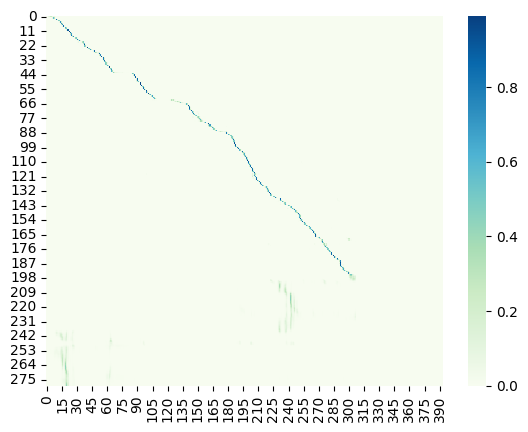

Saved best model


In [ ]:
gc.collect()
torch.cuda.empty_cache()
#total_wer = torch.tensor(0)
best_lev_dist = float("inf")
tf_rate = 1

for epoch in range(0, config['epochs']):
    
    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    # Call train and validate, get attention weights from training

    # model, dataloader, criterion, optimizer, teacher_forcing_rate
    train_loss, running_perplexity, attention_plot = train(model,train_loader, criterion, optimizer,tf_rate)
    valid_dist, total_wer = validate(model, val_loader)

    # Print your metrics
    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
    print("\tVal Dist {:.04f}\t".format(valid_dist))
    print("\tTeacher Forcing Ratio {}\t".format(tf_rate))

    wandb.log({
        'train_loss': train_loss,  
        'valid_dist': valid_dist, 
        'lr'        : curr_lr,
        'tf_ratio'  : tf_rate
    })
    print("Average WordErrorRate", total_wer/19 )
    # Plot Attention for a single item in the batch
    plot_attention(attention_plot[0].cpu().detach().numpy())

    # Log metrics to Wandb

    # Optional: Scheduler Step / Teacher Force Schedule Step
    if epoch > 10:
      scheduler.step()
    if (valid_dist < 30 or epoch >15) and tf_rate > 0.6:
      tf_rate*=0.985
    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        save_path = "Run3_model_{0}_{1}_{2}.pth".format(config['lr'],config['batch_size'],model.name)
        save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, save_path)
        wandb.save(save_path)
        print("Saved best model")
        # Save your model checkpoint here

# Testing

In [ ]:
def testing(model, dataloader):

    results = []
    model.eval()

    # batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Testing")

    running_lev_dist = 0.0

    for i, (x,lx) in enumerate(dataloader):

        x, lx = x.to(DEVICE), lx

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None)

        greedy_predictions   = torch.argmax(raw_predictions, dim=2) # TODO: How do you get the most likely character from each distribution in the batch?

        del x, lx
        results.extend(greedy_predictions)
    return results

In [ ]:
checkpoint = torch.load("/content/rerun_run2_model_0.001_150_LAS.pth")
model_dict = checkpoint["model_state_dict"]
# opt_dict = checkpoint["optimizer_state_dict"]
# sched_dict = checkpoint["scheduler_state_dict"]
model.load_state_dict(model_dict)
# optimizer.load_state_dict(opt_dict)
# scheduler.load_state_dict(sched_dict)


<All keys matched successfully>

In [ ]:
results = testing(model, test_loader)
results

In [ ]:
valid_dist = validate(model, val_loader)

In [ ]:
valid_dist

4.850175438596492

In [ ]:
# Optional: Load your best model Checkpoint here

# TODO: Create a testing function similar to validation 
results = testing(model, test_loader)
# TODO: Create a file with all predictions 
with open('submission_new.csv', 'w') as file:
  file.write("index,label\n")
  for i, pred in enumerate(results):
    pred_sliced = indices_to_chars(results[i], VOCAB)
    pred_string = ''.join(pred_sliced)
    file.write(f"{i},{pred_string}\n")


In [ ]:
!kaggle competitions submit -c 11-785-s23-hw4p2 -f submission_new.csv -m "Finally done"

100% 294k/294k [00:00<00:00, 1.14MB/s]
Successfully submitted to Attention-Based Speech Recognition